# Model proto

This is a rough prototype of our RL solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

if '..' not in sys.path: sys.path.append('..')
from src.utils import *
from src.actions import *
from src.units import *
from src.game_utils import *
from src.agent import DnDAgent
from src.game_board import DnDBoard

## Sample agent game

In [2]:
agent = DnDAgent(None, lr=0.001, board_shape=(5, 5), epsilon_delta=1e-4, in_channels=6, out_actions=2, batch_size=128)
iters = []

In [3]:
def create_same_game(board_size = (5, 5)):
    game = DnDBoard(board_size)
    ally = GenericSoldier("Ally soldier", attack_damage=100)
    ally.actions[0].range = 2
    ally2 = GenericSoldier("Ally dmg soldier", 1, 50, 25)
    enemy = GenericSoldier("Enemy soldier", attack_damage=100)
    enemy.actions[0].range = 2
    enemy2 = GenericSoldier("Enemy tank soldier", 1, 250, 4)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
    # place_unit_randomly(game, ally2, 0)
    # place_unit_randomly(game, enemy2, 1)
   
    game.initialize_game()

    color_map = {
        ally: "Green",
        enemy: "Red",
        ally2: "Blue",
        enemy2: "Purple"
    }

    # print_game(game, color_map)

    return game, color_map

In [4]:
import time
from IPython.display import clear_output


def play_game(game, color_map, print_games=True, delay=0.5):
    game_over = False
    iter_ = 0

    if print_games:
        print_game(game, color_map)
        time.sleep(delay)
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_ += 1
        print_iter = print_games #iter_ % 10 == 0
#
        if print_iter:
            clear_output(wait=True)
            print(f'Iteration: {iter_}')
    
        state = game.observe_board()
        new_coords, action, action_tuple = agent.choose_action(state)
    
        reward, game_over = take_turn(game, new_coords, action, color_map, True, print_iter, print_iter)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_tuple, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_tuple
        last_reward = reward
        
        if print_games: time.sleep(delay)
    
    if print_games: print(f'\nGame over in {iter_} iterations. Current epsilon = {agent.epsilon}')

    return iter_

In [5]:
games = 500
from tqdm.auto import tqdm

with tqdm(range(games), desc='Game') as pbar:
    for i in pbar:
        game, color_map = create_same_game()
        agent.game = game
        its = play_game(game, color_map, False)
        iters.append(its)

Game:   0%|          | 0/500 [00:00<?, ?it/s]

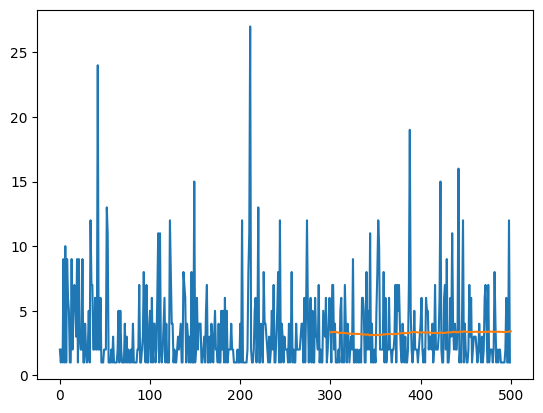

In [6]:
start_from = 0

itersl = iters[start_from:]
n = 300
plt.plot(itersl)
smoth = np.convolve(itersl, np.ones(n) / n, mode='valid')
plt.plot(range(n, len(smoth) + n), smoth)
plt.show()

In [7]:
agent.epsilon

0.8361000000000169

In [8]:
game, color_map = create_same_game()
agent.game = game
play_game(game, color_map, delay=1)

Iteration: 3
Turn made by player #0: `Ally soldier`:
	Unit moves: (2, 3) -> (2, 1);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'Enemy soldier'}

Units alive: 1
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (0 units)  
	
    0 1 2 3 4
 0            0 
 1            1 
 2   ██       2 
 3            3 
 4            4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`

Game over in 3 iterations. Current epsilon = 0.835800000000017


3

# Visualization

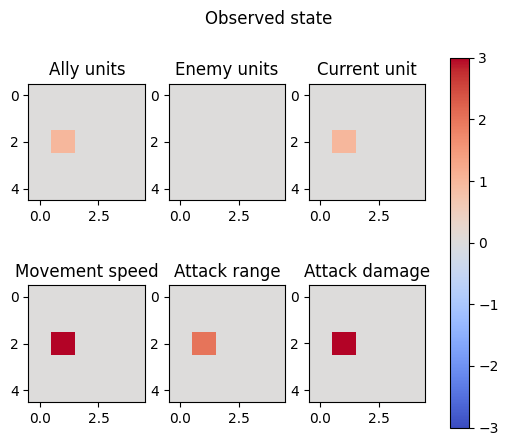

In [9]:
state = game.observe_board()
plot_featuremaps(
    state, 
    name='Observed state', 
    fm_names=['Ally units', 'Enemy units', 'Current unit', 'Movement speed', 'Attack range', 'Attack damage'],
    vmin = -3,
    vmax = 3,
)

In [10]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0            0 
 1            1 
 2         ██ 2 
 3            3 
 4     ██     4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`


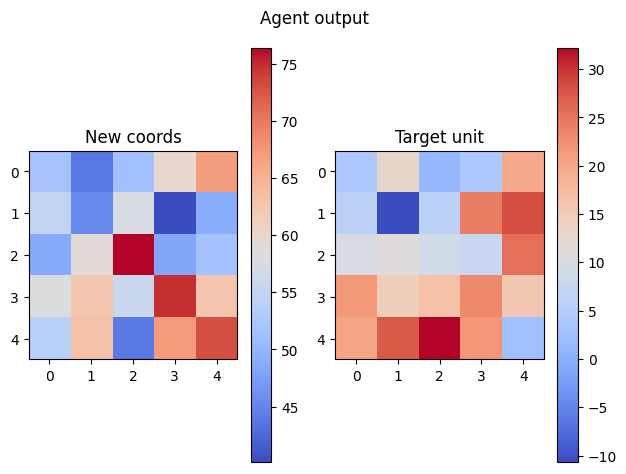

((1, 3), (4, 2))


In [14]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    name='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True,
)

print(agent.choose_action(state)[2])